# Plot Path

Given an ordered set of cells, produces downstream visualizations. To be used in conjunction with Paga.ipynb and operates on outputs of that notebook. Refer to PAGA graph for paths.

In [13]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(RColorBrewer)

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [4]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster, pseudotime coordinates
metaData = read.table("./sessions/20200223_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

,sample,umap.1,umap.2,cluster,dpt_pseudotime,barcode
,<fct>,<dbl>,<dbl>,<int>,<dbl>,<list>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,0.00000000,AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,0.03794836,AAACAACGACTCACGG


In [6]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [7]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [10]:
x.sp

number of barcodes: 74838
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [11]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

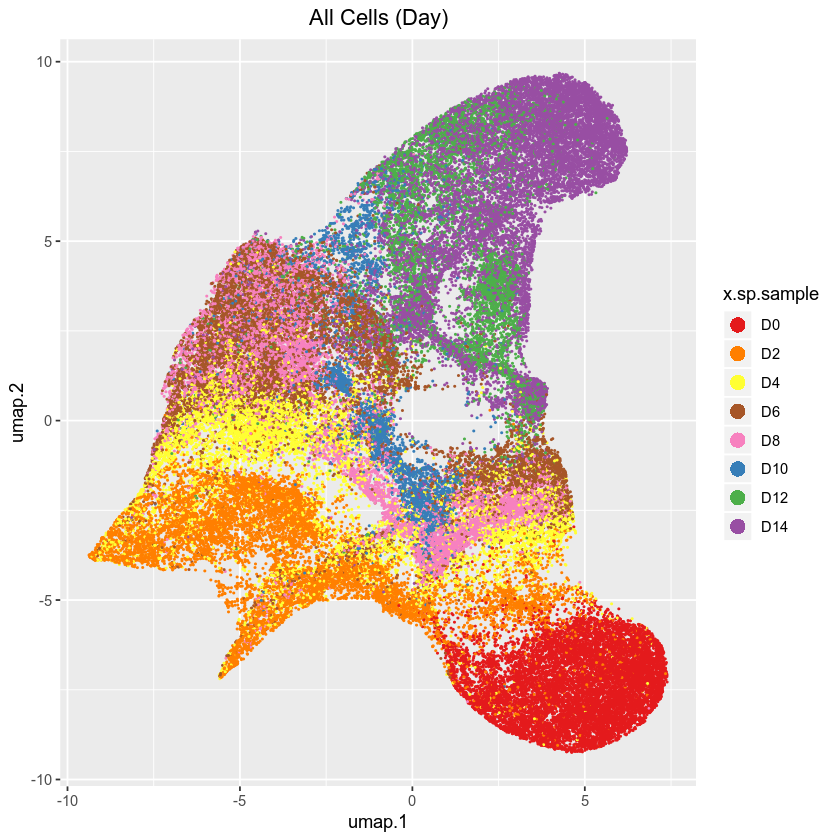

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

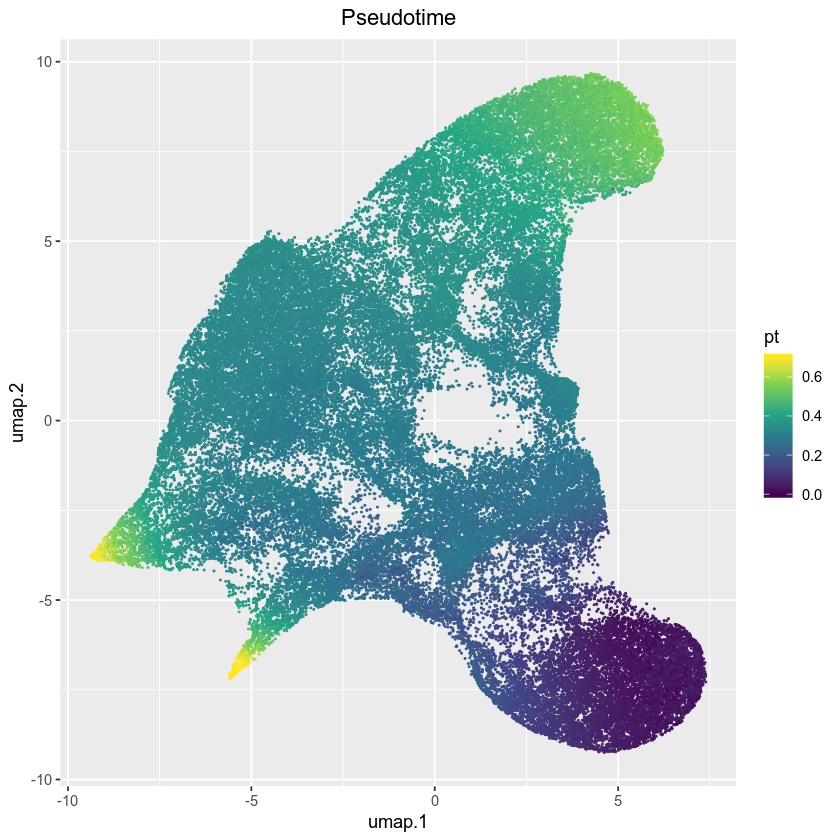

In [361]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, pt=metaData$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=pt)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.7), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

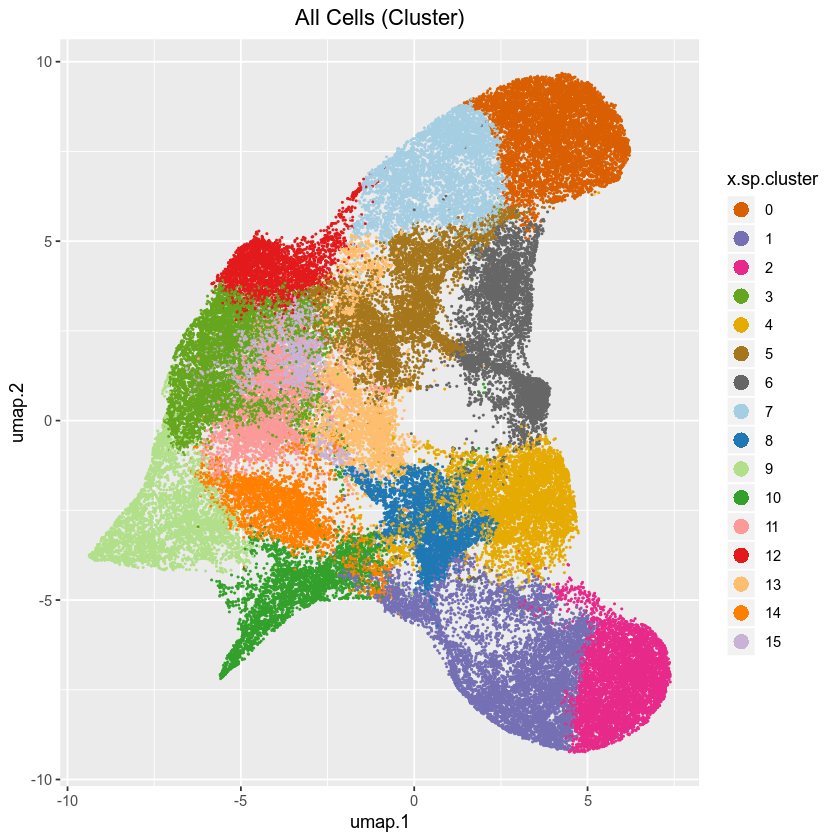

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.2, alpha=1) +
scale_colour_manual(values = col_vector[seq(10,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [17]:
table(x.sp@sample[x.sp@cluster=="13"])


 D10  D12  D14   D2   D4   D6   D8 
1642   41   98   17  484  254  524 

In [18]:
# Load ChromVAR
chromvar = read.table(gzfile("../20200206_pmat_snapATAC/sessions/20200220_n74838/chromvar.tsv.gz"), 
                      sep='\t')
head(chromvar)

,sample,cluster,umap1,umap2,NFIL3,FOXF2,FOXD1,IRF2,MZF1,MZF1.var.2.,⋯,RORC,SOX15,TFE3,VDR,EGR1,IRF3,IRF4,IRF5,TCF7L1,SOX2
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACAACGACGATTAC,D0,2,6.545686,-7.701751,-0.06097807,0.12900294,0.122682143,0.023708799,-0.03350387,-0.07210584,⋯,-0.10363258,-0.1276290,0.02889678,-0.0340200459,-0.075238083,0.003078155,0.06416149,-0.002606375,-0.08757322,-0.2251834
D0_AAACAACGACTCACGG,D0,2,5.180663,-7.633298,0.26096212,0.03433481,0.104098022,-0.185325253,-0.08978110,-0.05341638,⋯,0.10424267,-0.2191960,0.17636990,-0.2097924698,-0.008060946,-0.063758849,0.04202541,0.032557515,-0.06418007,-0.1404634
D0_AAACATGGAGACTCGC,D0,14,3.282927,-8.525186,-0.10669436,0.06854084,0.097844393,0.083130153,-0.05967191,-0.01202470,⋯,-0.00557459,-0.1212425,0.04607286,0.0019279775,-0.003432089,-0.002754538,0.16756656,0.160021886,-0.01633408,-0.1156646
D0_AAACATGGATGGGCCT,D0,2,5.934059,-7.776163,-0.10171912,0.10719553,0.002820288,0.004389487,-0.06426016,-0.05802489,⋯,0.01462824,-0.1895438,0.01488373,0.0212876103,-0.060171236,-0.019553484,0.12198716,0.022614238,-0.08929770,-0.2130389
D0_AAACCGTACCTTTAGG,D0,14,2.642430,-8.592471,-0.04850392,0.02195831,-0.016123743,-0.077041036,-0.04410459,-0.03302936,⋯,-0.01220366,-0.1826004,-0.03180454,0.0206026068,-0.017879214,-0.021853683,0.05807207,-0.037356593,-0.10338177,-0.1911633
D0_AAACGAAACCTCGATA,D0,14,3.109288,-8.751338,-0.10340678,-0.01207520,0.012081353,-0.063036310,-0.06229271,-0.07745096,⋯,-0.09863718,-0.1471419,-0.05464891,-0.0004016025,-0.093914726,-0.042500021,0.05470886,-0.008151317,-0.16273989,-0.2358124


## Plot a Path

In [412]:
clusters_in_path = c(2, 1, 14, 13, 15,11, 3, 12, 7, 0)
# clusters_in_path = c(14, 13, 15,11, 3)
# clusters_in_path = c(2, 1, 10)
# clusters_in_path = c(2, 1, 14, 9)

In [413]:
cells_in_path = metaData[metaData$cluster %in% clusters_in_path, ]
cells_in_path = cells_in_path[order(cells_in_path$dpt_pseudotime), ]
dim(cells_in_path)

[1] 47005     6

In [414]:
SUBSAMPLE_TO = 5000

step = floor(nrow(cells_in_path)/SUBSAMPLE_TO)
cells_in_path = cells_in_path[seq(1, nrow(cells_in_path), step), ]
dim(cells_in_path)

[1] 5223    6

In [415]:
df = data.frame(x.sp@umap, x.sp@sample, in_path_alpha=ifelse(x.sp@cluster %in% clusters_in_path, 1, 0))

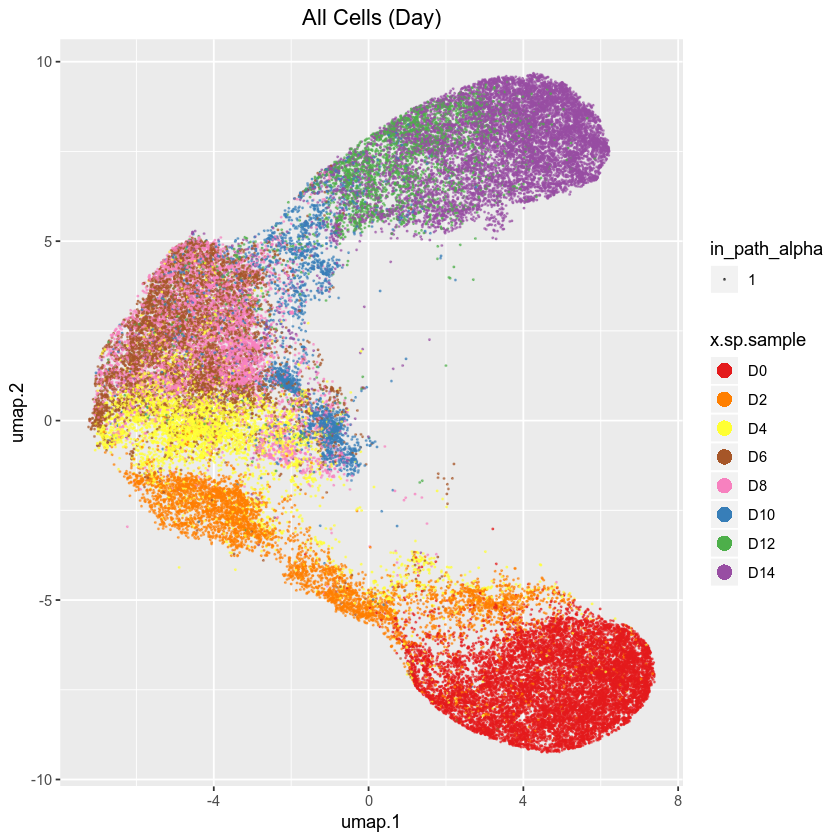

In [416]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample, cluster=x.sp@cluster,
                in_path_alpha=ifelse(x.sp@cluster %in% clusters_in_path, 1, 0))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df[df$cluster %in% clusters_in_path,]) +
geom_point(size=0.2, aes(x=umap.1 , y=umap.2, col=x.sp.sample, alpha=in_path_alpha)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

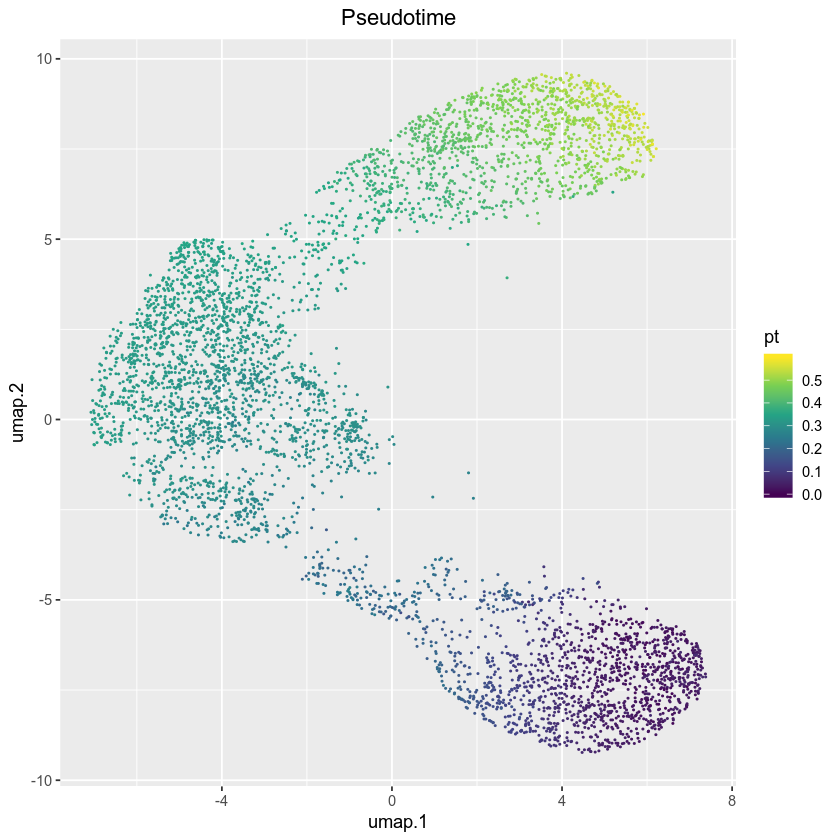

In [417]:
options(repr.plot.width = 7, repr.plot.height = 7)
df = data.frame(cells_in_path[,c("umap.1", "umap.2")], pt=cells_in_path$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=pt)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.6), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

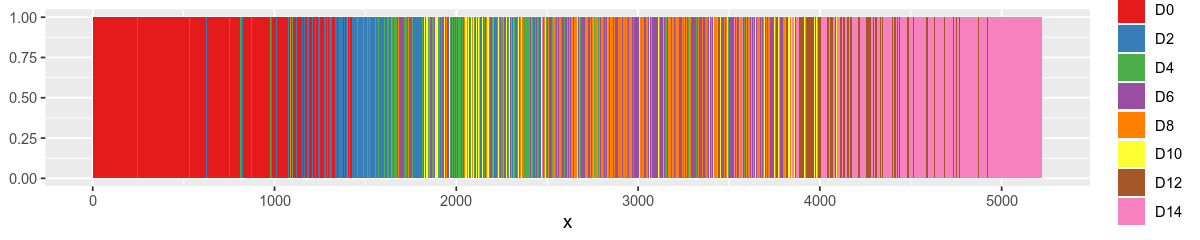

In [418]:
options(repr.plot.width = 10, repr.plot.height = 2)

cur_df = data.frame(x=seq(1,nrow(cells_in_path)),
                    d=factor(cells_in_path$sample,
                            levels=DAYS))
ggplot(cur_df) +
geom_col(aes(x=x, y=1, fill=d),  width=1) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
ylab(NULL)

## Plot ChromVAR

In [419]:
motif_df = t(chromvar[rownames(cells_in_path),5:ncol(chromvar)])

# remove NAs
motif_df = motif_df[, colSums(is.na(motif_df))==0]

head(motif_df)
dim(motif_df)

,D0_AAACAACGACGATTAC,D0_GGTTCAATGTCTGTAG,D0_CAAGATAGATAGCGAG,D0_ACAGACTACGCTGTTA,D0_GTTAAGAGATGGCATT,D0_AGTTCACGAATGTCCA,D0_CAATCAGACACCTGCG,D0_GGTTGTATGCCACTTC,D0_GCACAATACACGCCAC,D0_GATGCGCACCCCGAGT,⋯,D14_GACACCGTGCCTAGCG,D14_TCACCCATGTGGAACG,D14_GTGCAGAGAGCTGGCT,D14_TGCCATCTGGCTTCGG,D14_CATGCAAACGGAATGC,D14_TCATTGGGAACCTTGA,D14_TATGGTTCTACCTTGA,D14_AATGTGCTGTGTTGTG,D14_AGCGTATACATAACCC,D14_GGCACAAGACATACTG
NFIL3,-0.06097807,-0.04428635,0.01732163,-0.033851405,-0.04907319,-0.15717984,0.26400709,-0.120645200,-0.00130017,0.001091175,⋯,-0.24313434,0.11733219,-0.01488348,0.17386518,0.14432369,0.04262499,-0.451301221,0.05266764,0.17346871,0.005258372
FOXF2,0.12900294,0.21501055,0.08125107,0.025335277,0.10609387,0.07937129,0.22518722,0.103077503,0.23234306,0.051606519,⋯,0.05858621,0.20466557,0.11314456,0.22784692,0.20521515,0.05814960,0.258553239,0.07155639,0.15182581,0.345623835
FOXD1,0.12268214,0.02319600,0.01812541,-0.038541829,0.05274066,0.10623497,0.19759239,0.177167318,0.08612247,0.084044527,⋯,0.21540155,0.22682107,0.30904748,0.58557210,0.37083422,0.12999033,0.417662966,0.21999550,0.10538112,0.204797771
IRF2,0.02370880,0.01933340,0.05333098,0.101657318,-0.07110243,0.01436476,0.04643609,-0.006512714,0.03257232,-0.073456435,⋯,0.19513023,0.08324391,0.08718606,-0.08651688,-0.11242929,0.17359117,0.223821228,0.26304606,-0.02773374,0.073564882
MZF1,-0.03350387,-0.03324022,-0.04166209,-0.062709432,-0.03256662,-0.04511801,-0.03586405,-0.050898744,-0.06236736,-0.044252892,⋯,0.03867167,-0.07177831,-0.09126064,-0.01113429,0.02466211,-0.03893522,-0.008759984,0.03942670,0.10321044,0.030584499
MZF1.var.2.,-0.07210584,0.01085133,-0.04606588,0.003894486,-0.04193480,-0.08676724,-0.08805343,-0.046766764,-0.06302100,-0.061423238,⋯,-0.04109972,-0.04813727,0.16080133,0.08093805,0.08228453,0.02082008,-0.058830423,-0.01859808,0.29804547,0.225576220


[1]  453 5186

In [420]:
# remove redundant motifs
motif_cors = cor(t(motif_df), method='spearman')
motif_cors[upper.tri(motif_cors)] = 0
diag(motif_cors) = 0
motif_df = motif_df[!apply(motif_cors,1,function(x) any(x > 0.85)), ]
dim(motif_df)                           

[1]  332 5186

In [421]:
# z-norm per cell (there seemed to be a trended bias such that most motifs at later days had higher motif scores)
motif_df = scale(motif_df)

# clip quantiles
clip <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}

motif_df = t(apply(motif_df, 1, clip))

# scale to 0-1
motif_df = motif_df - apply(motif_df, 1, min)
motif_df = motif_df/apply(motif_df, 1,max)

In [422]:
# smooth
motif_df_smooth = t(apply(motif_df, 1, smooth))
colnames(motif_df_smooth) = colnames(motif_df)
motif_df = motif_df_smooth
dim(motif_df)

[1]  332 5186

In [423]:
TOP = 50

# choose top TOP by variance
row_vars = apply(motif_df, 1, var)
motif_df = motif_df[rev(order(row_vars))[1:TOP], ]

In [424]:
# take subset
# tf_list = c("POU5F1", "SOX2", "KLF4", "ZBTB7B", "CTCF", "YY1", "TFAP2B", 
#                      "BACH2", "JUNB", "FOXC2", "FOXB1", "ATF4", "JUN", "CEBPA")
# motif_df = motif_df[tf_list, ]

In [425]:
# order rows (motifs)
row_distance = dist(t(scale(t(motif_df))))
row_cluster = hclust(row_distance, method="ward")
row_dendrogram = as.dendrogram(row_cluster)
rowInd = rev(order.dendrogram(row_dendrogram))

motif_df_row_ordered = as.matrix(motif_df[rowInd, ])
head(motif_df_row_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



,D0_AAACAACGACGATTAC,D0_GGTTCAATGTCTGTAG,D0_CAAGATAGATAGCGAG,D0_ACAGACTACGCTGTTA,D0_GTTAAGAGATGGCATT,D0_AGTTCACGAATGTCCA,D0_CAATCAGACACCTGCG,D0_GGTTGTATGCCACTTC,D0_GCACAATACACGCCAC,D0_GATGCGCACCCCGAGT,⋯,D14_GACACCGTGCCTAGCG,D14_TCACCCATGTGGAACG,D14_GTGCAGAGAGCTGGCT,D14_TGCCATCTGGCTTCGG,D14_CATGCAAACGGAATGC,D14_TCATTGGGAACCTTGA,D14_TATGGTTCTACCTTGA,D14_AATGTGCTGTGTTGTG,D14_AGCGTATACATAACCC,D14_GGCACAAGACATACTG
CUX1,0.1740197,0.1740197,0.1740197,0.1862894,0.2137085,0.2271220,0.227122,0.1885538,0.0329888,0.0329888,⋯,0.5752000,0.5752000,0.5752000,0.4888168,0.4014131,0.4014131,0.4014131,0.4589351,0.5339347,0.6839339
ONECUT1,0.1912314,0.1912314,0.1912314,0.1682414,0.1682414,0.1682414,0.116668,0.1166680,0.1166680,0.1166680,⋯,0.4337732,0.4337732,0.4956915,0.5541434,0.5630371,0.5630371,0.5630371,0.5630371,0.6022096,0.6191453


In [426]:
melted = melt(motif_df_row_ordered[, seq(1,ncol(motif_df_row_ordered), 10)])
melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [427]:
head(melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,CUX1,D0_AAACAACGACGATTAC,0.1740197
2,ONECUT1,D0_AAACAACGACGATTAC,0.1912314


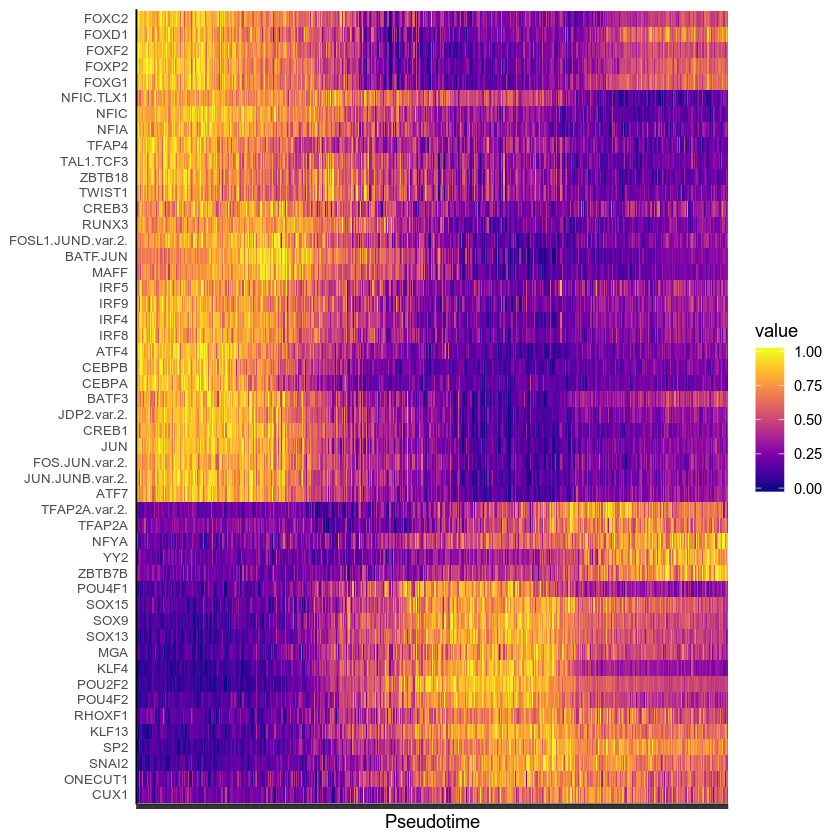

In [428]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='C') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
theme_classic() +
theme(axis.text.x=element_blank(),
      axis.text.y=element_text(angle=0,hjust=1, size=8),
#       axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
#       panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

## Plot Raw Peaks

In [429]:
x.sp.path = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(cells_in_path), ]

# sort by pseudotime
x.sp.path = x.sp.path[order(cells_in_path[paste(x.sp.path@sample, x.sp.path@barcode, sep='_'), "dpt_pseudotime"]),]

In [430]:
# check orders are the same
all(paste(x.sp.path@sample, x.sp.path@barcode, sep='_')==rownames(cells_in_path))

[1] TRUE

In [431]:
# choose peaks with sufficient counts, but not too high
peak_frac = Matrix::colMeans(x.sp.path@pmat)
q = quantile(peak_frac[peak_frac>0], c(0.3,0.8))

In [432]:
q*100

30%       80% 
0.4786521 2.4506988

In [433]:
x.sp.path = x.sp.path[, (peak_frac>q[1])&(peak_frac<q[2]), "pmat"]

In [434]:
x.sp.path

number of barcodes: 5223
number of bins: 0
number of genes: 0
number of peaks: 224620
number of motifs: 0

In [442]:
PEAKS_TO_SAMPLE = 10000
peak_mat = x.sp.path@pmat[, sample(ncol(x.sp.path@pmat), PEAKS_TO_SAMPLE)]

In [444]:
# shuffling for NULL
# peak_mat = peak_mat[sample(nrow(peak_mat)), ]

In [445]:
# choose peaks that aren't spread too much
pt_vars = apply(peak_mat, 2, function (x) {var(which(x>0))})
peak_mat = as.matrix(peak_mat[, pt_vars < quantile(pt_vars, 0.1)])

In [446]:
# sort by median
peak_mat_row_ordered = as.matrix(t(peak_mat[,order(apply(peak_mat, 2, function (x) {median(which(x>0))}))]))
colnames(peak_mat_row_ordered) = rownames(cells_in_path)

In [447]:
# extend each peak EXTEND steps in pseudotime
EXTEND = 10
extend_peaks <- function(x) {
    mileage = 0
    for (i in seq(length(x))) {
        if (x[i]>0) {
            mileage = EXTEND
        }
        else {
            if (mileage>0) {
                x[i] = 1
                mileage = mileage - 1
            }
        }
    }
    
    x
}

peak_mat_row_ordered = t(apply(peak_mat_row_ordered, 1, extend_peaks))

In [448]:
melted = melt(as.matrix(peak_mat_row_ordered[, seq(1,ncol(peak_mat_row_ordered), 10)]))
# melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [449]:
head(melted, 2)

,Var1,Var2,value
,<int>,<fct>,<dbl>
1,1,D0_AAACAACGACGATTAC,0
2,2,D0_AAACAACGACGATTAC,0


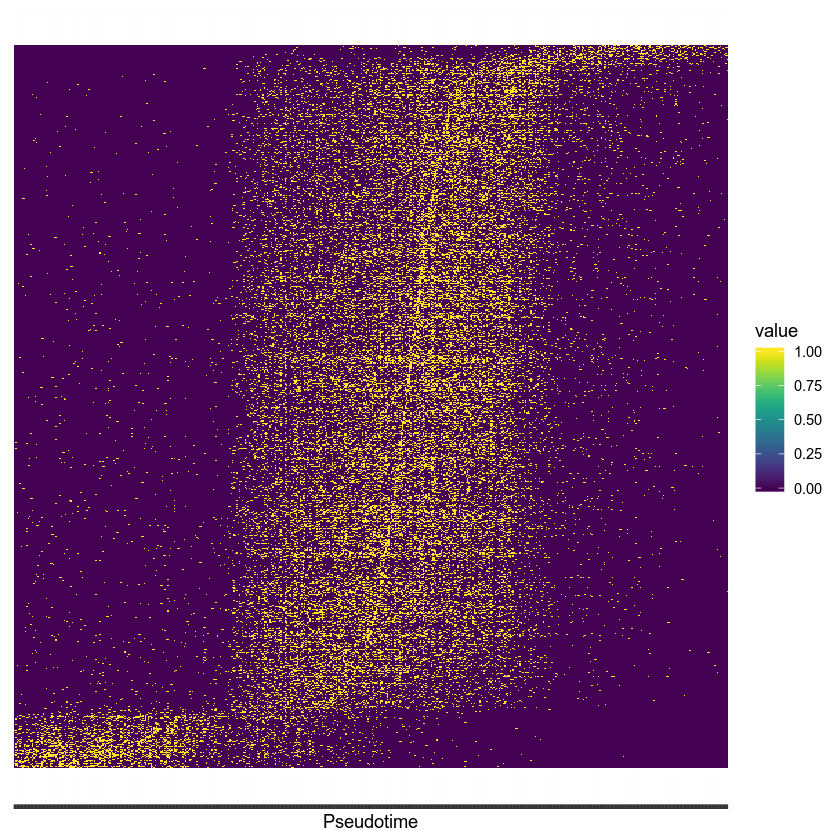

In [441]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='D') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_text(angle=0,hjust=1, size=8),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

In [107]:
plot(seq(1,ncol(peak_mat_row_ordered)), peak_mat_row_ordered[1001,]>0)

ERROR: Error in peak_mat_row_ordered[1001, ]: subscript out of bounds
